In [9]:
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
import random
import torch
#from tensorflow.keras.preprocessing.image import ImageDataGenerator

  category                img_path        size
0     Meat   ./Dataset/Meat/63.jpg  (512, 384)
1     Meat  ./Dataset/Meat/823.jpg  (512, 512)
2     Meat  ./Dataset/Meat/189.jpg  (512, 512)
3     Meat   ./Dataset/Meat/77.jpg  (512, 382)
4     Meat  ./Dataset/Meat/837.jpg  (512, 512)


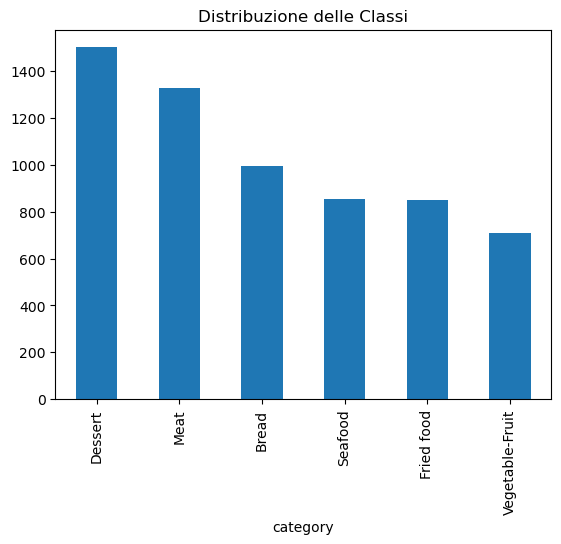

In [10]:

dataset_dir = './Dataset'
data = []
categories = os.listdir(dataset_dir)


for category in categories:
    folder_path = os.path.join(dataset_dir, category)
    # Verifica che sia effettivamente una directory
    if os.path.isdir(folder_path):
        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            try:
                # Prova ad aprire l'immagine per verificarne la qualità
                img = Image.open(img_path)
                data.append({'category': category, 'img_path': img_path, 'size': img.size})
            except:
                print(f"Immagine corrotta: {img_path}")

# Crea un DataFrame dai dati raccolti
df = pd.DataFrame(data)
print(df.head())

# Visualizza la distribuzione delle classi
df['category'].value_counts().plot(kind='bar')
plt.title('Distribuzione delle Classi')
plt.show()


# Pre - Processing

Classe: Meat


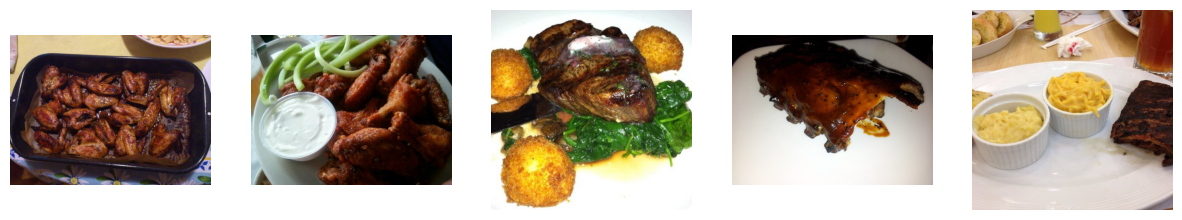

Classe: Dessert


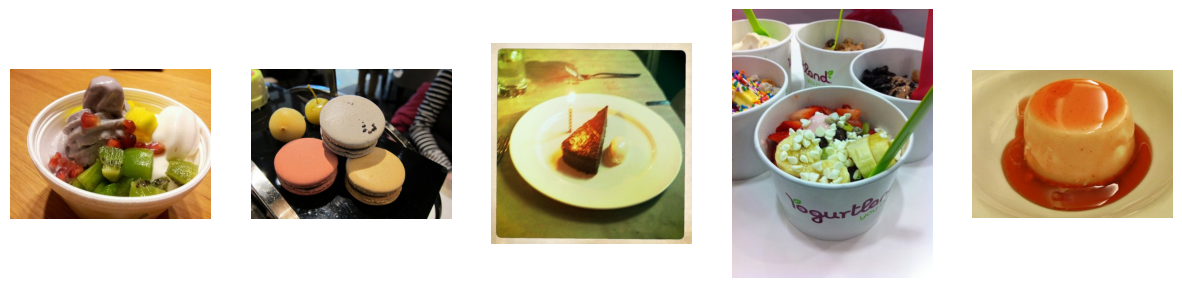

Classe: Vegetable-Fruit


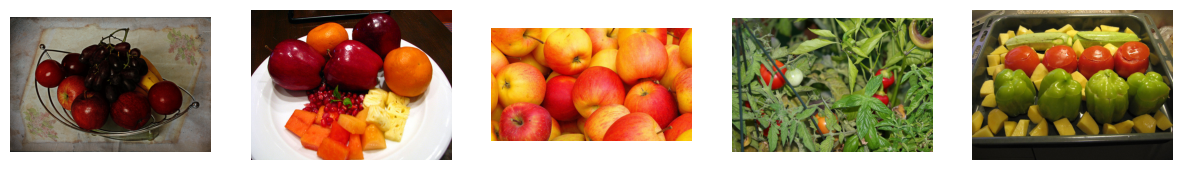

Classe: Seafood


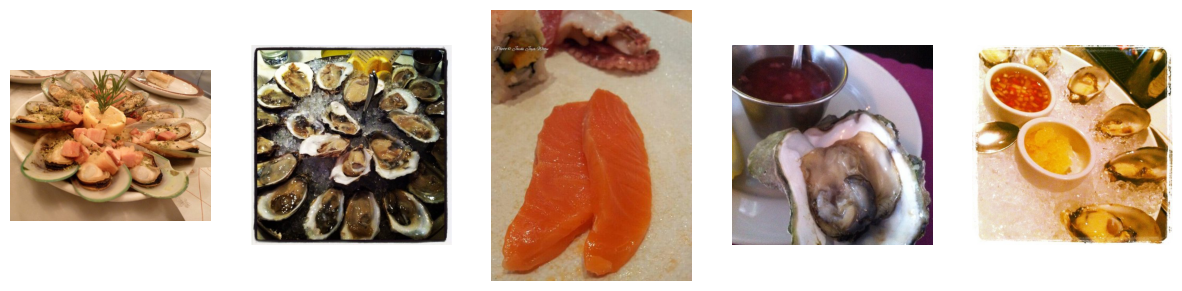

Classe: Bread


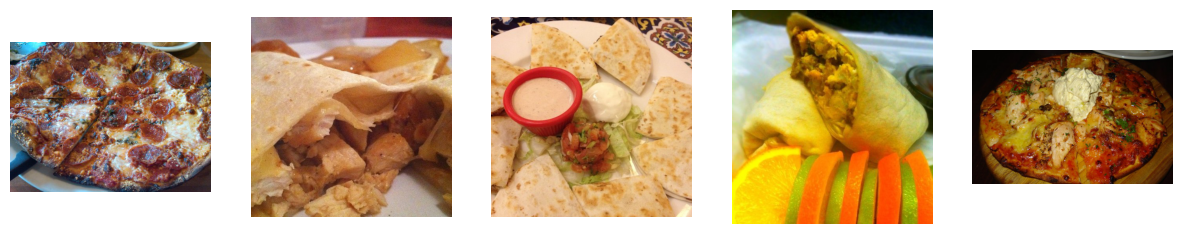

Classe: Fried food


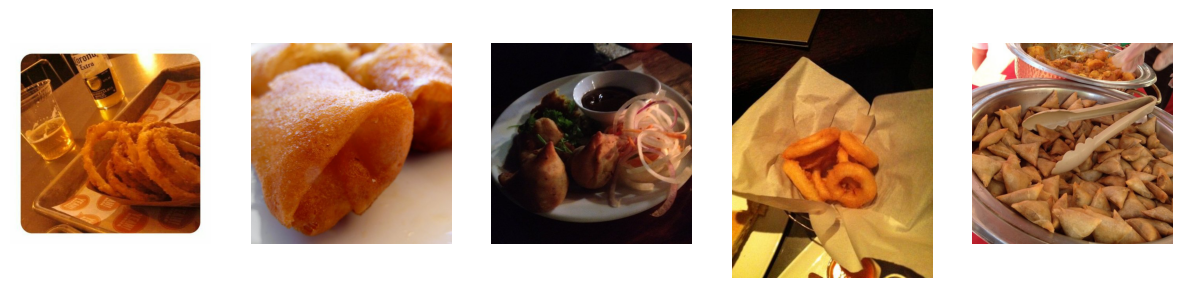

In [11]:
# Funzione per visualizzare un campione di immagini per ogni classe
def visualizza_immagini(dataset_dir, n=5):
    categories = os.listdir(dataset_dir)
    for category in categories:
        folder_path = os.path.join(dataset_dir, category)
        if os.path.isdir(folder_path):
            print(f"Classe: {category}")
            imgs = random.sample(os.listdir(folder_path), n)
            fig, ax = plt.subplots(1, n, figsize=(15, 5))
            for i, img_name in enumerate(imgs):
                img_path = os.path.join(folder_path, img_name)
                img = Image.open(img_path)
                ax[i].imshow(img)
                ax[i].axis('off')
            plt.show()

# Visualizza un campione di immagini da ciascuna classe
visualizza_immagini('./Dataset', n=5)


In [12]:
def rimuovi_immagini_corrotte(dataset_dir):
    categories = os.listdir(dataset_dir)
    for category in categories:
        folder_path = os.path.join(dataset_dir, category)
        if os.path.isdir(folder_path):
            for img_name in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_name)
                try:
                    img = Image.open(img_path)
                    img.verify()  # Verifica la correttezza dell'immagine
                except (IOError, SyntaxError):
                    print(f"Rimuovendo immagine corrotta: {img_path}")
                    os.remove(img_path)

# Esegui la funzione per rimuovere immagini corrotte
rimuovi_immagini_corrotte('./Dataset')


In [13]:
# Definizione delle trasformazioni
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Ridimensiona le immagini
    transforms.ToTensor(),  # Converte le immagini in tensori
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalizzazione
])


# Data Augmentation *

In questa sezione abbiamo creato una nuova directory chiamata Datasetc_Augmentation, che continee un insieme di immagini modificate a partire dal dataset di partenza, il numero di osservazioni per classe è pari ad un numero che compensa la dimensione non equilibrata delle classe.

EX:

Se la classe Meat ha 400 record e la media delle osservazioni è 1200 allora a Meat verranno inseriti 800 osservazioni.

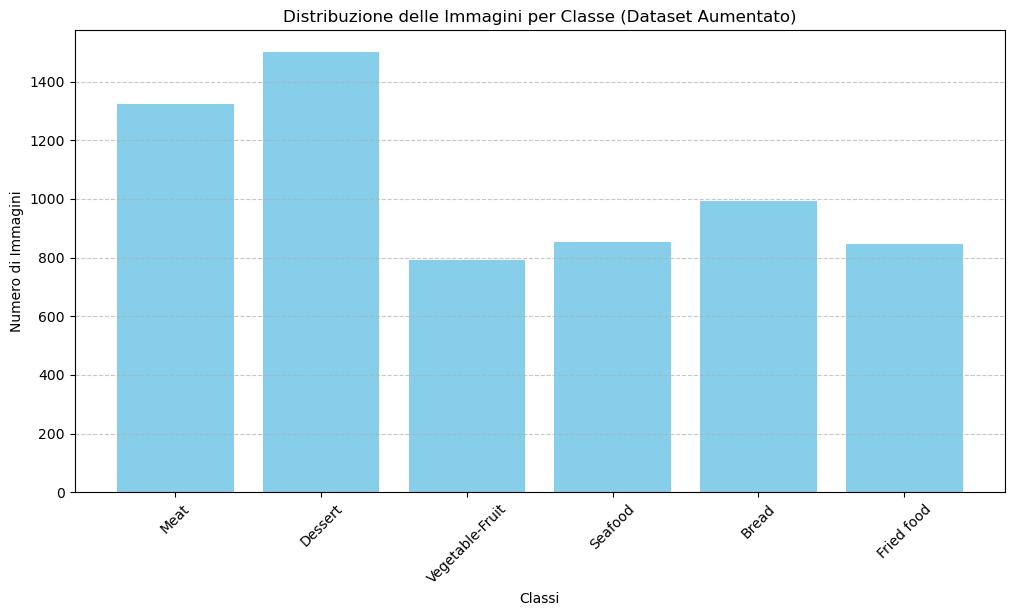

In [34]:
from torchvision import transforms
from PIL import Image
import os
import random
import matplotlib.pyplot as plt

# Directory originale del dataset e directory di destinazione per le immagini aumentate
dataset_dir = './Dataset'
augmented_dataset_dir = './Dataset_Augmented'

# Creazione della directory per le immagini aumentate se non esiste
os.makedirs(augmented_dataset_dir, exist_ok=True)

# Definizione delle trasformazioni di data augmentation
augmentation_transform = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=(0.8, 1.2)),
    transforms.RandomAffine(degrees=0, shear=0.2),
    transforms.RandomResizedCrop((224, 224), scale=(0.8, 1.2)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomAffine(degrees=20, translate=(0.2, 0.2))
])

# Funzione per bilanciare le classi con meno elementi
def balance_classes(input_dir, output_dir, target_count=None):
    # Controlla tutte le categorie (sottocartelle) presenti nella directory di input
    categories = [d for d in os.listdir(input_dir) if os.path.isdir(os.path.join(input_dir, d))]
    # Crea un dizionario con il conteggio delle immagini per ogni categoria, escludendo file non immagine
    class_counts = {category: len([f for f in os.listdir(os.path.join(input_dir, category)) 
                                   if os.path.isfile(os.path.join(input_dir, category, f)) and not f.startswith('.')]) 
                    for category in categories}

    # Imposta il target_count come il massimo delle classi, se non specificato
    if target_count is None:
        target_count = max(class_counts.values())

    # Itera su ciascuna categoria per bilanciare il numero di immagini
    for category in categories:
        category_path = os.path.join(input_dir, category)
        output_category_path = os.path.join(output_dir, category)

        # Assicurati che la directory di output esista
        os.makedirs(output_category_path, exist_ok=True)

        # Conta le immagini nella categoria corrente
        current_count = len([f for f in os.listdir(output_category_path) 
                             if os.path.isfile(os.path.join(output_category_path, f))])

        # Se la classe ha già abbastanza immagini, passa alla successiva
        if current_count >= target_count:
            continue  
        
        # Continua a generare immagini aumentate finché non si raggiunge il target_count
        while current_count < target_count:
            try:
                # Seleziona casualmente un'immagine esistente nella categoria
                img_name = random.choice([f for f in os.listdir(category_path) 
                                          if os.path.isfile(os.path.join(category_path, f)) and not f.startswith('.')])
                img_path = os.path.join(category_path, img_name)

                # Apri l'immagine, applica le trasformazioni e salva l'immagine aumentata
                img = Image.open(img_path).convert('RGB')
                augmented_img = augmentation_transform(img)
                augmented_img_path = os.path.join(output_category_path, f'aug_{current_count}.jpeg')
                augmented_img.save(augmented_img_path)

                # Incrementa il conteggio delle immagini
                current_count += 1
            except Exception as e:
                print(f"Errore nell'elaborazione dell'immagine {img_path}: {e}")

# Bilancia le classi nel dataset aumentato
balance_classes(dataset_dir, augmented_dataset_dir)

# Funzione per contare il numero di immagini per classe
def conta_immagini_per_classe(directory):
    class_counts = {}
    categories = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
    for category in categories:
        class_counts[category] = len([f for f in os.listdir(os.path.join(directory, category)) 
                                      if os.path.isfile(os.path.join(directory, category, f)) and not f.startswith('.')])
    return class_counts

# Funzione per visualizzare il numero di immagini per classe
def visualizza_distribuzione_immagini(class_counts, title):
    plt.figure(figsize=(12, 6))
    plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
    plt.xlabel('Classi')
    plt.ylabel('Numero di Immagini')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Conta le immagini per classe nel dataset aumentato
class_counts_augmented = conta_immagini_per_classe(augmented_dataset_dir)

# Visualizza la distribuzione delle immagini per classe nel dataset aumentato
visualizza_distribuzione_immagini(class_counts_augmented, "Distribuzione delle Immagini per Classe (Dataset Aumentato)")


In [35]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Directory per il dataset unico e per i set di training e test
combined_dataset_dir = './Combined_Dataset'
train_dir = './Train_Dataset'
test_dir = './Test_Dataset'

# Creazione delle directory se non esistono
os.makedirs(combined_dataset_dir, exist_ok=True)
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Funzione per combinare le immagini originali e aumentate in un'unica directory
def combine_datasets(original_dir, augmented_dir, combined_dir):
    categories = [d for d in os.listdir(original_dir) if os.path.isdir(os.path.join(original_dir, d))]
    for category in categories:
        # Creazione delle directory per ogni classe nel dataset combinato
        combined_category_path = os.path.join(combined_dir, category)
        os.makedirs(combined_category_path, exist_ok=True)

        # Copia delle immagini originali
        original_category_path = os.path.join(original_dir, category)
        for img_name in os.listdir(original_category_path):
            img_path = os.path.join(original_category_path, img_name)
            if os.path.isfile(img_path):
                shutil.copy(img_path, combined_category_path)

        # Verifica se la directory aumentata esiste prima di copiare le immagini
        augmented_category_path = os.path.join(augmented_dir, category)
        if os.path.exists(augmented_category_path):
            # Copia delle immagini aumentate
            for img_name in os.listdir(augmented_category_path):
                img_path = os.path.join(augmented_category_path, img_name)
                if os.path.isfile(img_path):
                    shutil.copy(img_path, combined_category_path)
        else:
            print(f"Directory aumentata mancante per la classe: {category}")

# Combina i dataset originale e aumentato
combine_datasets(dataset_dir, augmented_dataset_dir, combined_dataset_dir)

# Funzione per dividere il dataset combinato in training e test
def split_dataset(input_dir, train_output_dir, test_output_dir, test_size=0.2):
    categories = [d for d in os.listdir(input_dir) if os.path.isdir(os.path.join(input_dir, d))]
    for category in categories:
        category_path = os.path.join(input_dir, category)
        images = [f for f in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, f))]

        # Suddivisione delle immagini tra training e test
        train_images, test_images = train_test_split(images, test_size=test_size, random_state=42)

        # Creazione delle directory per il training e test
        train_category_path = os.path.join(train_output_dir, category)
        test_category_path = os.path.join(test_output_dir, category)
        os.makedirs(train_category_path, exist_ok=True)
        os.makedirs(test_category_path, exist_ok=True)

        # Copia delle immagini nel set di training
        for img_name in train_images:
            img_path = os.path.join(category_path, img_name)
            shutil.copy(img_path, train_category_path)

        # Copia delle immagini nel set di test
        for img_name in test_images:
            img_path = os.path.join(category_path, img_name)
            shutil.copy(img_path, test_category_path)

# Divide il dataset combinato in set di training e test
split_dataset(combined_dataset_dir, train_dir, test_dir)

# Visualizzazione del numero di immagini in training e test per verifica
print("Immagini nel set di training:")
print(conta_immagini_per_classe(train_dir))
print("\nImmagini nel set di test:")
print(conta_immagini_per_classe(test_dir))


Immagini nel set di training:
{'Meat': 2120, 'Dessert': 2400, 'Vegetable-Fruit': 1200, 'Seafood': 1368, 'Bread': 1590, 'Fried food': 1356}

Immagini nel set di test:
{'Meat': 530, 'Dessert': 600, 'Vegetable-Fruit': 300, 'Seafood': 342, 'Bread': 398, 'Fried food': 340}


# VARIANZA - MEDIA 
Discussione

In [36]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Trasformazione per convertire le immagini in tensori senza altre modifiche
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()  # Converti l'immagine in tensore [C, H, W] con valori tra 0 e 1
])

# Funzione per calcolare la media, varianza e deviazione standard di un dataset
def calcola_statistiche(dataset_dir):
    dataset = datasets.ImageFolder(dataset_dir, transform=transform)
    loader = DataLoader(dataset, batch_size=32, shuffle=False)

    # Somme per calcolare media e varianza
    mean_sum = torch.zeros(3)
    var_sum = torch.zeros(3)
    count = 0

    for images, _ in loader:
        # Somma delle medie dei canali
        mean_sum += images.mean([0, 2, 3]) * images.size(0)
        # Somma della varianza dei canali
        var_sum += images.var([0, 2, 3], unbiased=False) * images.size(0)
        count += images.size(0)

    # Media totale per canale
    mean = mean_sum / count
    # Varianza totale per canale
    variance = var_sum / count
    # Deviazione standard per canale
    std_dev = torch.sqrt(variance)

    return mean, variance, std_dev

# Calcolo delle statistiche per il set di training
train_mean, train_variance, train_std_dev = calcola_statistiche(train_dir)
print(f"Training Set - Media: {train_mean}, Varianza: {train_variance}, Deviazione Standard: {train_std_dev}")

# Calcolo delle statistiche per il set di test
test_mean, test_variance, test_std_dev = calcola_statistiche(test_dir)
print(f"Test Set - Media: {test_mean}, Varianza: {test_variance}, Deviazione Standard: {test_std_dev}")


Training Set - Media: tensor([0.4899, 0.3885, 0.2910]), Varianza: tensor([0.0896, 0.0814, 0.0747]), Deviazione Standard: tensor([0.2994, 0.2853, 0.2733])
Test Set - Media: tensor([0.4868, 0.3831, 0.2848]), Varianza: tensor([0.0899, 0.0801, 0.0733]), Deviazione Standard: tensor([0.2998, 0.2831, 0.2707])
